In [337]:
from pykalman import KalmanFilter
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import seaborn as sns
from typing import List
from scipy.linalg import block_diag
import numpy.ma as ma

# Notes

- kalman filter seems to perform worse when we try to account for missing data. We determined missing frames by inspecting timestamp data an calculate approximatly how many frames should be between timestamps (`timestamps_to_steps()`). Then we insert the missing elements into the data array and mask the "missing" entries. The masked array was then submitted to the kalman filer `smooth()` method and the returned data decoded by removing the previously masked indicies. We found great surprise on the subsequent junctions, as large as 40 degrees for angles and 40 px for position (x or y).

In [373]:
def plot_coords(x, y):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(24, 5))
    axs[0].plot(x)
    axs[0].set_ylabel('X position')
    axs[1].plot(y)
    axs[1].set_ylabel('Y position')
    axs[1].set_xlabel('Frame #')
    return fig, axs

def plot_angles(angles, unwrap=True):
    fig, axs = plt.subplots(1, 1, sharex=True, figsize=(24, 2.5))
    if unwrap:
        angles = angles.copy()
        angles = np.unwrap(angles, period=360)
        angles = np.mod(angles, 360)
    axs.plot(angles)
    axs.set_ylabel('angle')
    axs.set_xlabel('Frame #')
    return fig, axs

def plot_hist(data):
    fig, axs = plt.subplots(1, 1, sharex=True)
    return sns.histplot(data, ax=axs)

def plot_angles_polar(angles):
    fig, axs = plt.subplots(1, 1, figsize=(24, 24), subplot_kw={'projection':'polar'})
    angles = angles.copy()
    angles = np.unwrap(angles, period=360)
    angles = np.mod(angles, 360)

    axs.set_theta_zero_location('E')
    axs.set_theta_direction(1)
    plt.plot(angles, np.arange(angles.shape[0]))

def plot_coords_2d(x, y, z=None, use_z=True, zlabel="Frame #", figsize=None, ax=None, cmap="plasma"):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = None
    if z is None:
        z = np.arange(x.shape[0])
    if use_z:
        plot_color_line(ax, x, y, z, zlabel=zlabel, cmap=cmap)
    else:
        ax.plot(x, y, c='k', linestyle='dashed')
    ax.set_ylabel('Y position')
    ax.set_xlabel('X position')
    return fig, ax

def plot_color_line(ax, x, y, z, cmap="plasma", zlabel="Frame #"):
    """ Plots a line that varies in color according to `z` and `cmap` 

    Parameters:
        ax (matplotlib axis instance): Axis to plot on
        x (numpy array-like): x data
        y (numpy array-like): y data
        z (numpy array-like): z data (used for color)
        cmap (colormap): Colormap instance or color map name
        zlabel (string): label for colorbar
    """
    #cmap = plt.get_cmap(cmap)
    if np.nanmin(z) < 0 and np.nanmax(z) > 0:
        norm = mcolors.CenteredNorm(vcenter=0)
    else:
        norm = plt.Normalize()

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(z)
    lc.set_linewidth(1.2)
    ax.add_collection(lc)

    min_value = min([np.nanmin(x), np.nanmin(y)])
    max_value = max([np.nanmax(x), np.nanmax(y)])

    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_aspect('equal')
    ax.set_anchor('C')

    axcb = plt.colorbar(lc)
    axcb.set_label(zlabel)

    return
#end plot_color_line()

def angle_difference(angles1, angles2):
    diff = (angles2 - angles1) % 360
    to_min = diff > 180
    diff[to_min] = -(360 - diff[to_min])
    return diff

(35994, 2)
(35994,)
(35994,)


(<Figure size 1728x180 with 1 Axes>,
 <AxesSubplot:xlabel='Frame #', ylabel='angle'>)

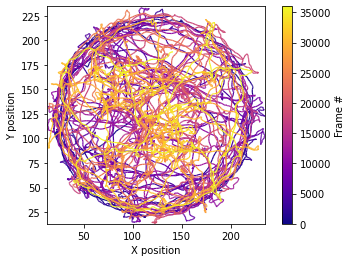

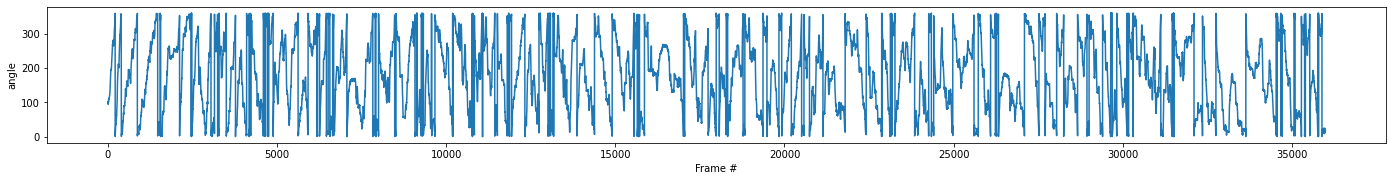

In [339]:
dataset_path = r"E:\moseq_raw_data\detectron2_testing_full\session_20200806170816_top-score-vote\result_00.h5"
with h5py.File(dataset_path) as h5:
    centroids = np.stack((h5['/scalars/centroid_x_px'][()], h5['/scalars/centroid_y_px'][()]), axis=1)
    angles = h5['/scalars/angle'][()]
    timestamps = h5['/timestamps'][()]
    # angles = np.unwrap(h5['/scalars/angle'][()], period=360)
    # angles = np.mod(h5['/scalars/angle'][()] + 180, 360) - 180
    # angles = np.mod(h5['/scalars/angle'][()], 360)
    #kpts = np.zeros((h5['/frames'].shape[0], len(default_keypoint_names), 2))
    #for kpi, kp in enumerate(default_keypoint_names):
    #    for dimi, dim in enumerate(('x', 'y')):
    #        kpts[:, kpi, dimi] = h5[f'/keypoints/reference/{kp}_{dim}_px']
#kpts = kpts.reshape(-1, len(default_keypoint_names)*3)
#print(kpts.shape)
print(centroids.shape)
print(angles.shape)
print(timestamps.shape)


plot_coords_2d(centroids[:, 0], centroids[:, 1])
plot_angles(angles)

In [377]:
def timestamps_to_steps(timestamps, step_size=(1/30 * 1000)):
    ''' Generate an array containing the discrete number of time steps between each observation

    Args:
        timestamps: array of observation times
        step_size: the expected delay between time steps

    Returns:
        array with the number of discrete time steps observed between subsequent observations, of shape (timestamps.shape[0] - 1,)
    '''
    return np.rint(np.diff(timestamps) / step_size).astype(int)


def expand_missing_entries(data, time_steps):
    ''' Expand an array `data` to add entries where observations are missing
        as defined by `time_steps`. This is the inverse operation of `reduce_missing_entries()`
        when provided with the same `time_steps`.

        `data` may be n-dimentional, but the first dimention should encode time

        Example:
        > data =    np.array([0, 1, 3, 4, 8, 9, 10])
        > missing = np.array([1, 2, 1, 4, 1, 1])
        > expand_missing_entries(data, missing)
        masked_array(data=[0, 1, --, 3, 4, --, --, --, 8, 9, 10],
                     mask=[False, False,  True, False, False,  True,  True,  True, False, False, False])

        Args:
            data: contiguous array of observations
            time_steps: data defining the number of discrete time steps between observations

        Returns:
            array of shape (sum(time_steps)+1,), with missing observations masked
    '''
    out_shape = (np.sum(time_steps)+1, *data.shape[1:])
    full = np.zeros(out_shape, dtype=data.dtype)
    mask = np.zeros(out_shape, dtype='int')
    i = 0
    for j, k in enumerate(time_steps):
        # print(j, k, i, "->", data[j])
        full[i] = data[j]
        if k == 1:
            mask[i] = 0
        else:
            mask[i+1:i+k] = 1
        i += k
    full[i] = data[j+1]
    return ma.masked_array(full, mask=mask)


def reduce_missing_entries(data, time_steps):
    ''' Reduce an array `data` to remove entries where observations are missing
        as defined by `time_steps`. This is the inverse operation of `expand_missing_entries()`
        when provided with the same `time_steps`.

        `data` may be n-dimentional, but the first dimention should encode time

        Example:
        > data =    np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        > missing = np.array([1, 2, 1, 4, 1, 1])
        > reduce_missing_entries(data, missing)
        array([0, 1, 3, 4, 8, 9, 10])

        Args:
            data: contiguous array of observations
            time_steps: data defining the number of discrete time steps between observations

        Returns:
            array of shape (time_steps.shape[0]+1,), with missing observations removed
    '''

    reduced = np.zeros((time_steps.shape[0] + 1, *data.shape[1:]), dtype=data.dtype)
    i = 0
    for j, k in enumerate(time_steps):
        # print(j, k, i, "->", data[i])
        reduced[j] = data[i]
        i += k
    reduced[j+1] = data[i]
    return reduced


class KalmanTrackerItem():
    def __init__(self, order: int=3, delta_t: float=1.0):
        self.order = order
        self.delta_t = delta_t
        self.state_size = self.build_observ_mat().shape[-1]

    def build_trans_mat(self):
        pass

    def build_observ_mat(self):
        pass

    def build_init_state_means(self, data: np.ndarray):
        pass

    def format_data(self, data: np.ndarray):
        return data

    def inverse_format_data(self, data: np.ndarray):
        return data[:, ::self.order]


class KalmanTrackerPoint1D(KalmanTrackerItem):

    def get_derivitives(self):
        return [
            1.0,                         # position
            self.delta_t,                # velocity
            pow(self.delta_t, 2) / 2,    # acceleration
            pow(self.delta_t, 3) / 6     # jerk
        ][:self.order]

    def build_trans_mat(self):
        ''' Build transition matrix for this point
        '''
        derivitives = self.get_derivitives()
        trans_mat = np.zeros((self.order, self.order))
        for d in range(self.order):
            depends = range(d, self.order)
            for i, j in enumerate(depends):
                trans_mat[d, j] = derivitives[i]
        return trans_mat

    def build_observ_mat(self):
        ''' Build observation matrix
        '''
        observ_matrix = np.zeros((self.order,))
        observ_matrix[0] = 1
        return observ_matrix

    def build_init_state_means(self, data: np.ndarray):
        derivitives = self.get_derivitives()
        init_state_means = np.zeros((self.order,))
        init_state_means[0] = data[0]
        #for i in range(self.order):
        #    samples = data[:int((i+1 / 2) * 2)+1]
        #    print(samples)
        #    for j in range(i):
        #        samples = np.diff(samples) / derivitives[j]
        #        print(i, j, samples)
        #    init_state_means[i] = samples[0]
        return init_state_means


class KalmanTrackerAngle(KalmanTrackerPoint1D):
    def __init__(self, order: int=3, delta_t: float=1.0, mod: bool=True):
        super().__init__(order=order, delta_t=delta_t)
        self.mod = mod

    def format_data(self, data: np.ndarray):
        return np.unwrap(np.mod(data, 360) - 180, period=360)

    def inverse_format_data(self, data: np.ndarray):
        if self.mod:
            return np.mod(data[:, ::self.order], 360)
        return data[:, ::self.order]

class KalmanTrackerPoint2D(KalmanTrackerPoint1D):

    def build_trans_mat(self):
        ''' Build transition matrix for this point
        '''
        return block_diag(super().build_trans_mat(), super().build_trans_mat())

    def build_observ_mat(self):
        ''' Build observation matrix
        '''
        return block_diag(super().build_observ_mat(), super().build_observ_mat())

    def build_init_state_means(self, data: np.ndarray):
        return np.hstack((super().build_init_state_means(data[:, 0]),
                          super().build_init_state_means(data[:, 1])))


class KalmanTracker(object):
    ''' Object for kalman tracking
    '''

    def __init__(self, order: int=3, delta_t: float=1.0):
        '''
        Parameters:
        order (int): number between 1 and 4: 1=models position; 2=models position + velocity, 3=models position + velocity + acceleration;
                     4=models position + velocity + acceleration + jerk
        delta_t (float): time between model steps
        '''
        self.order = order
        self.delta_t = delta_t

        # these get set after calling initialize()
        self.kalman_filter: KalmanFilter = None
        self.num_points: int = None
        self.init_data: np.ndarray = None

        # these are only used with streaming obervations (i.e. using self.filter_update())
        self.last_mean: np.ndarray = None
        self.last_covar: np.ndarray = None

    @property
    def is_initialized(self) -> bool:
        ''' Has this tracker been initialized?
        '''
        return self.kalman_filter is not None

    def initialize(self, items_to_track: List[KalmanTrackerItem], init_data: np.ndarray):
        ''' Initialize the tracker with data
        Parameters:
        init_data (np.ndarray): initial data, of shape (nframes, npoints, 2 [x, y])
        '''
        self.items = items_to_track
        self.init_data = init_data#init_data.reshape(init_data.shape[0], -1)

        self.kalman_filter = KalmanFilter(
            transition_matrices=self._build_trans_mat(),
            observation_matrices=self._build_observ_matrix(),
            initial_state_mean=self._build_init_state_means(),
            em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance']
        )
        self.kalman_filter.em(self._format_data(self.init_data), n_iter=10)
        #state_means, state_covariances = self.kalman_filter.filter(self._format_data(self.init_data))
        self.last_mean = self.kalman_filter.initial_state_mean #list(state_means)[-1]
        self.last_covar = self.kalman_filter.initial_state_covariance #list(state_covariances)[-1]

    def _build_init_state_means(self) -> np.ndarray:
        ''' Build initial state mean matrix
        '''
        return np.hstack([itm.build_init_state_means(self.init_data[i]) for i, itm in enumerate(self.items)])

    def _build_trans_mat(self) -> np.ndarray:
        ''' Build transition matrix
        '''
        return block_diag(*[itm.build_trans_mat() for itm in self.items])

    def _build_observ_matrix(self) -> np.ndarray:
        ''' Build observation matrix
        '''
        return block_diag(*[itm.build_observ_mat() for itm in self.items])

    def _format_data(self, data):
        return np.column_stack([itm.format_data(data[i]) for i, itm in enumerate(self.items)])

    def _inverse_format_data(self, data):
        out = []
        offset = 0
        for i, itm in enumerate(self.items):
            out.append(itm.inverse_format_data(data[:, offset:offset+itm.state_size]))
            offset += itm.state_size
        return out

    def smooth(self, data: np.ndarray) -> np.ndarray:
        ''' Use the kalman filter to smooth data points
        '''
        to_smooth = self._format_data(data)
        means, _ = self.kalman_filter.smooth(to_smooth)
        return self._inverse_format_data(means)

    def filter(self, data: np.ndarray) -> np.ndarray:
        ''' Filter '''
        to_filter = self._format_data(data)
        means, covars = self.kalman_filter.filter(to_filter)
        return self._inverse_format_data(means)

    def filter_update(self, data: np.ndarray) -> np.ndarray:
        ''' Filter and update '''
        to_filter = self._format_data(data)
        mean, covar = self.kalman_filter.filter_update(
            self.last_mean,
            self.last_covar,
            to_filter,
        )
        self.last_mean = mean
        self.last_covar = covar
        return self._inverse_format_data(mean)

    def __str__(self) -> str:
        buffer = ""
        buffer += "transition_matrices:\n"
        buffer += str(self.kalman_filter.transition_matrices)
        buffer += "\n\n"

        buffer += "observation_matrices:\n"
        buffer += str(self.kalman_filter.observation_matrices)
        buffer += "\n\n"

        buffer += "transition_covariance:\n"
        buffer += str(self.kalman_filter.transition_covariance)
        buffer += "\n\n"

        buffer += "observation_covariance:\n"
        buffer += str(self.kalman_filter.observation_covariance)
        buffer += "\n\n"

        buffer += "transition_offsets:\n"
        buffer += str(self.kalman_filter.transition_offsets)
        buffer += "\n\n"

        buffer += "observation_offsets:\n"
        buffer += str(self.kalman_filter.observation_offsets)
        buffer += "\n\n"
        
        buffer += "initial_state_mean:\n"
        buffer += str(self.kalman_filter.initial_state_mean)
        buffer += "\n\n"

        buffer += "initial_state_covariance:\n"
        buffer += str(self.kalman_filter.initial_state_covariance)
        buffer += "\n\n"

        buffer += "n_dim_state:\n"
        buffer += str(self.kalman_filter.n_dim_state)
        buffer += "\n\n"

        buffer += "n_dim_obs:\n"
        buffer += str(self.kalman_filter.n_dim_obs)
        buffer += "\n\n"
        return buffer

    def __repr__(self) -> str:
        return str(self)

In [378]:
tracker = KalmanTracker(order=3, delta_t=1.0)
items = [
    KalmanTrackerPoint2D(order=3, delta_t=1.0),
    KalmanTrackerAngle(order=3, delta_t=1.0, mod=False)
]
data = [
    centroids[:1000, :],
    angles[:1000]
]
tracker.initialize(items, data)


In [379]:
tracker

transition_matrices:
[[1.  1.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  1.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  1.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  1.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]

observation_matrices:
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]]

transition_covariance:
[[ 0.78683984  0.07385688  0.05849853 -0.16847786  0.02331518 -0.00301947
   0.16436224 -0.03866407 -0.00939355]
 [ 0.07385688  0.68584189  0.00760363  0.01242979 -0.12191988  0.01291455
  -0.01221252  0.09622707 -0.01886257]
 [ 0.05849853  0.00760363  0.19633242 -0.0023674   0.0062288  -0.02410067
  -0.00226618  0.00688176  0.02492021]
 [-0.16847786  0.01242979 -0.0023674   0.21651357  0.12510671  0.05413342
  -0.05584998  0.00919528  0.00198556]
 [ 0.02331518 -0.12191988  0.0062288 

In [388]:
fr_start, fr_stop = (0, 36000)
steps = timestamps_to_steps(timestamps[fr_start:fr_stop])
# data = [
#     expand_missing_entries(centroids[fr_start:fr_stop], steps),
#     expand_missing_entries(angles[fr_start:fr_stop], steps)
# ]
data = [
    centroids[fr_start:fr_stop], steps,
    angles[fr_start:fr_stop], steps
]
smoothed_centroids, smoothed_angles = tracker.smooth(data)

#smoothed_centroids = reduce_missing_entries(smoothed_centroids, steps)
#smoothed_angles = reduce_missing_entries(smoothed_angles, steps)

centroid_diff = centroids[fr_start:fr_stop] - smoothed_centroids
formatted_angles = items[1].format_data(angles[fr_start:fr_stop])
angles_diff = angle_difference(smoothed_angles[:, 0], formatted_angles)

print(smoothed_centroids.shape, smoothed_angles.shape)
plot_coords_2d(smoothed_centroids[:, 0], smoothed_centroids[:, 1])
plot_coords(centroid_diff[:, 0], centroid_diff[:, 1])

plot_angles(formatted_angles, unwrap=False)
plot_angles(smoothed_angles, unwrap=False)
plot_angles(angles_diff, unwrap=False)
plot_angles(steps, unwrap=False)

plot_hist(angles_diff)
print(np.sum(np.abs(angles_diff)))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 35994 and the array at index 1 has size 35993

In [387]:
from scipy.signal import find_peaks
print(find_peaks(np.abs(steps), height=2))
find_peaks(np.abs(angles_diff), height=10)

(array([  147,  3003,  4740,  9076, 11817], dtype=int64), {'peak_heights': array([2., 2., 3., 2., 2.])})


(array([  147,  3003,  4740,  6370,  9076, 11817, 17741, 25902, 30951],
       dtype=int64),
 {'peak_heights': array([17.79743648, 10.45243919, 37.36083657, 11.29482142, 35.12448841,
         28.37035381, 10.43094968, 10.39507023, 21.68579708])})

In [ ]:
ktp2d = KalmanTrackerPoint2D(order=3, delta_t=1.0)
print(ktp2d.build_trans_mat())
print(ktp2d.build_observ_mat())
print(ktp2d.build_init_state_means(centroids[:1000, :]))
#ktp2d.format_data()

In [270]:
np.argmin(formatted_angles - smoothed_angles[:, 0])

30952

In [272]:
np.argmin(centroids[:,0] - smoothed_centroids[:, 0])

17740

(<Figure size 1728x180 with 1 Axes>,
 <AxesSubplot:xlabel='Frame #', ylabel='angle'>)

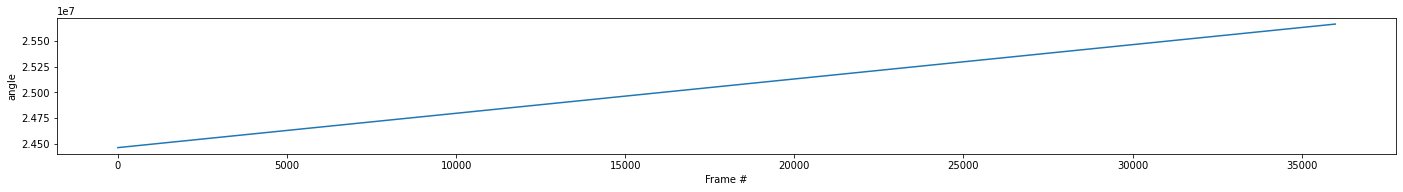

In [286]:
plot_angles(timestamps, unwrap=False)

(<Figure size 1728x180 with 1 Axes>,
 <AxesSubplot:xlabel='Frame #', ylabel='angle'>)

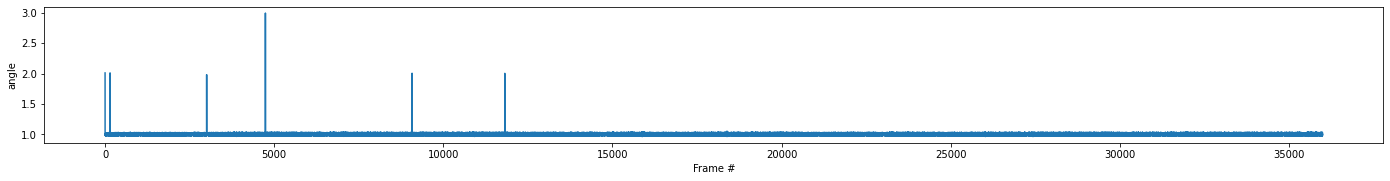

In [292]:
plot_angles(np.diff(timestamps) / (1/30 * 1000), unwrap=False)

(<Figure size 1728x180 with 1 Axes>,
 <AxesSubplot:xlabel='Frame #', ylabel='angle'>)

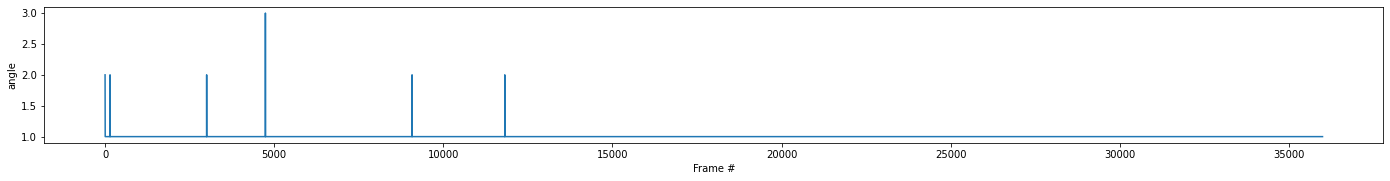

In [335]:
def timestamps_to_steps(timestamps, step_size=(1/30 * 1000)):
    return np.rint(np.diff(timestamps) / step_size).astype(int)

plot_angles(timestamps_to_steps(timestamps), unwrap=False)

In [294]:
set(timestamps_to_steps(timestamps))

{1.0, 2.0, 3.0}

In [369]:
data =    np.array([
    [0, 10],
    [1, 11],
    [3, 13],
    [4, 14],
    [8, 18],
    [9, 19],
    [10, 20],
])
print(data.shape)
missing = np.array([1, 2, 1, 4, 1, 1])
full = expand_missing_entries(data, missing)
print(full.shape)
print(full)

reduced = reduce_missing_entries(full, missing)
print(reduced.shape)
print(reduced)

(7, 2)
(11, 2)
[[0 10]
 [1 11]
 [-- --]
 [3 13]
 [4 14]
 [-- --]
 [-- --]
 [-- --]
 [8 18]
 [9 19]
 [10 20]]
0 1 0 -> [0 10]
1 2 1 -> [1 11]
2 1 3 -> [3 13]
3 4 4 -> [4 14]
4 1 8 -> [8 18]
5 1 9 -> [9 19]
(7, 2)
[[ 0 10]
 [ 1 11]
 [ 3 13]
 [ 4 14]
 [ 8 18]
 [ 9 19]
 [10 20]]


In [367]:

reduce_missing_entries(full, missing)

0 1 0 -> [0 10]
1 2 1 -> [1 11]
2 1 3 -> [3 13]
3 4 4 -> [4 14]
4 1 8 -> [8 18]
5 1 9 -> [9 19]


array([[ 0, 10],
       [ 1, 11],
       [ 3, 13],
       [ 4, 14],
       [ 8, 18],
       [ 9, 19],
       [10, 20]])

In [ ]:
def expand_missing_entries(data, time_steps):
    ''' Expand an array `data` to add entries where observations are missing
        as defined by `time_steps`

        Example:
        > data =    np.array([0, 1, 3, 4, 8, 9, 10])
        > missing = np.array([1, 2, 1, 4, 1, 1])
        > expand_missing_entries(data, missing)
        masked_array(data=[0, 1, --, 3, 4, --, --, --, 8, 9, 10],
                     mask=[False, False,  True, False, False,  True,  True,  True, False, False, False])

        Args:
            data: contiguous array of observations
            time_steps: data defining the number of discrete time steps between observations

        Returns:
            array of shape (sum(time_steps)+1,), with missing observations masked
    '''
    out_shape = (np.sum(time_steps)+1,)
    full = np.zeros(out_shape, dtype=data.dtype)
    mask = np.zeros(out_shape, dtype='int')
    i = 0
    for j, k in enumerate(time_steps):
        print(j, k, i, "->", data[j])

        full[i] = data[j]
        if k == 1:
            mask[i] = 0
        else:
            mask[i+1:i+k] = 1
        i += k
    full[i] = data[j+1]
    return ma.masked_array(full, mask=mask)